# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from PMF import *
from general_utils import *
from polytope_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "General_Polytope"

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# Source Generation and Mixing Scenario

In [2]:
dim = 5
N = 10000
NumberofSources = dim
NumberofMixtures = 10

signed_dims = np.array([0, 1, 3])
nn_dims = np.array([2, 4])
sparse_dims_list = [np.array([0, 1, 4]), np.array([1, 2, 3])]
(A, b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
Sgt = generate_uniform_points_in_polytope(V, N)

# Generate Mxr random mixing from i.i.d N(0,1)
Agt = np.random.randn(NumberofMixtures, NumberofSources)
Y = np.dot(Agt, Sgt)

SNR = 30
Y, NoisePart = addWGN(Y, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Y - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(Agt)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.026639276886442


# Visualize Generated Sources and Mixtures

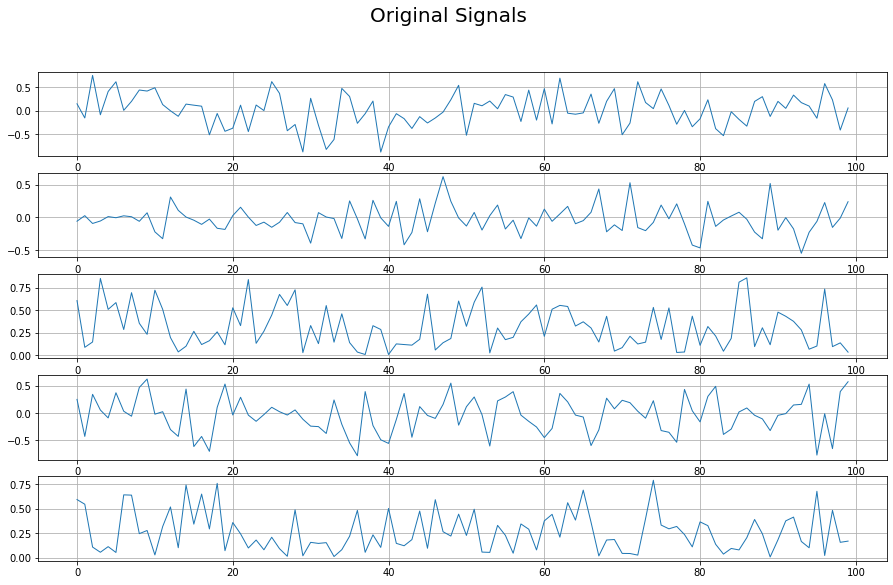

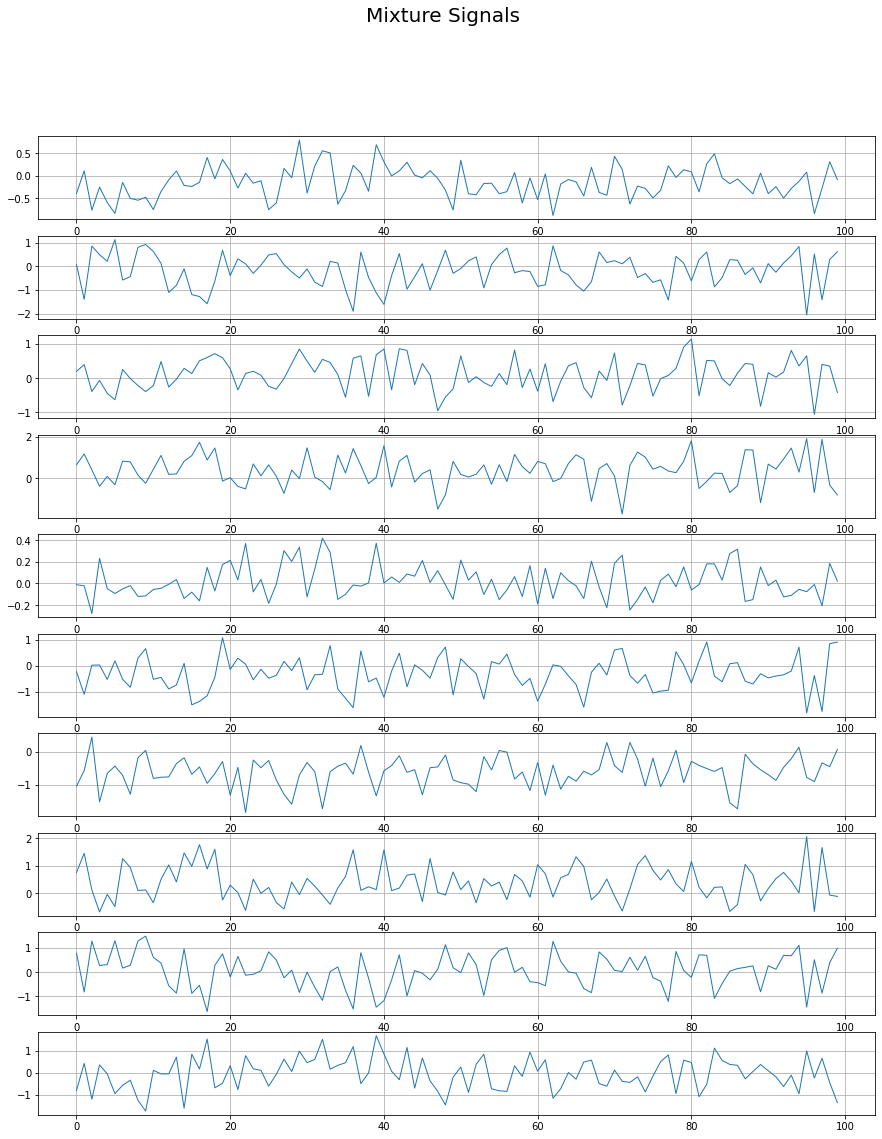

In [3]:
subplot_1D_signals(
    Sgt[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    Y[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
s_dim = Sgt.shape[0]
y_dim = Y.shape[0]
debug_iteration_point = 5000
model = PMF(s_dim=s_dim, y_dim=y_dim, set_ground_truth=True, Sgt=Sgt, Agt=Agt)

# Run PMF Algorithm on Mixture Signals

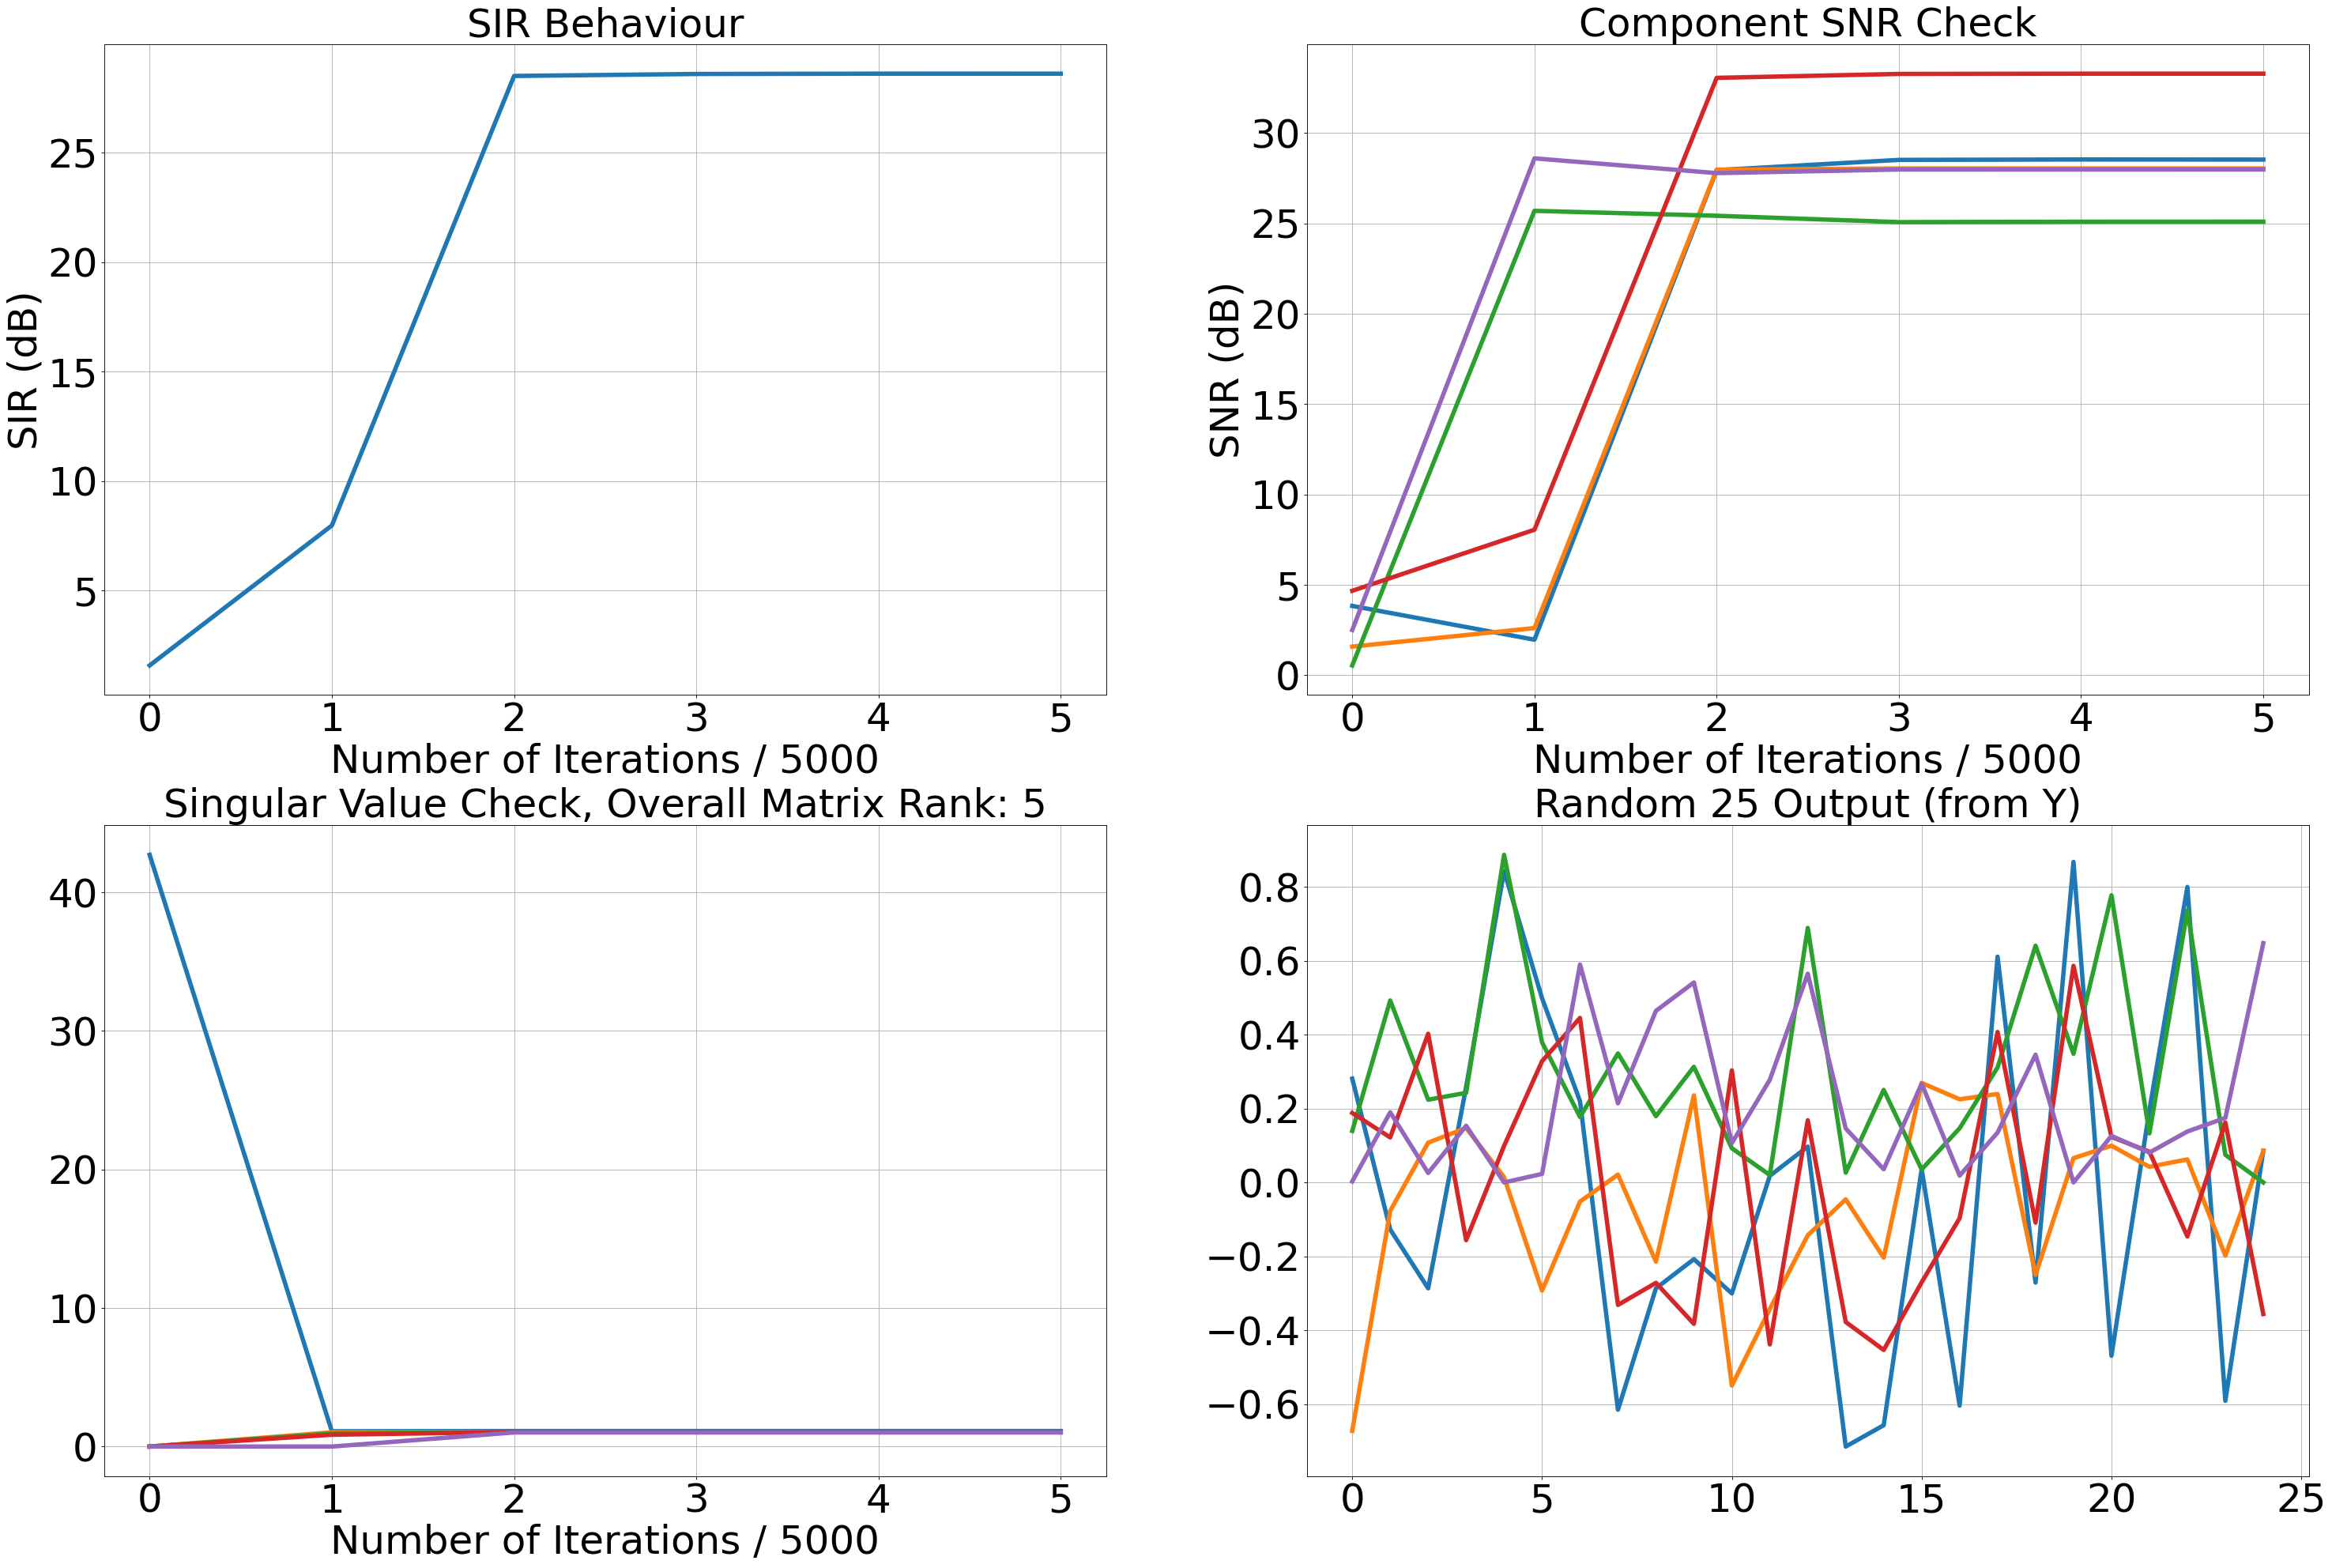

100%|██████████| 25000/25000 [02:46<00:00, 149.84it/s]


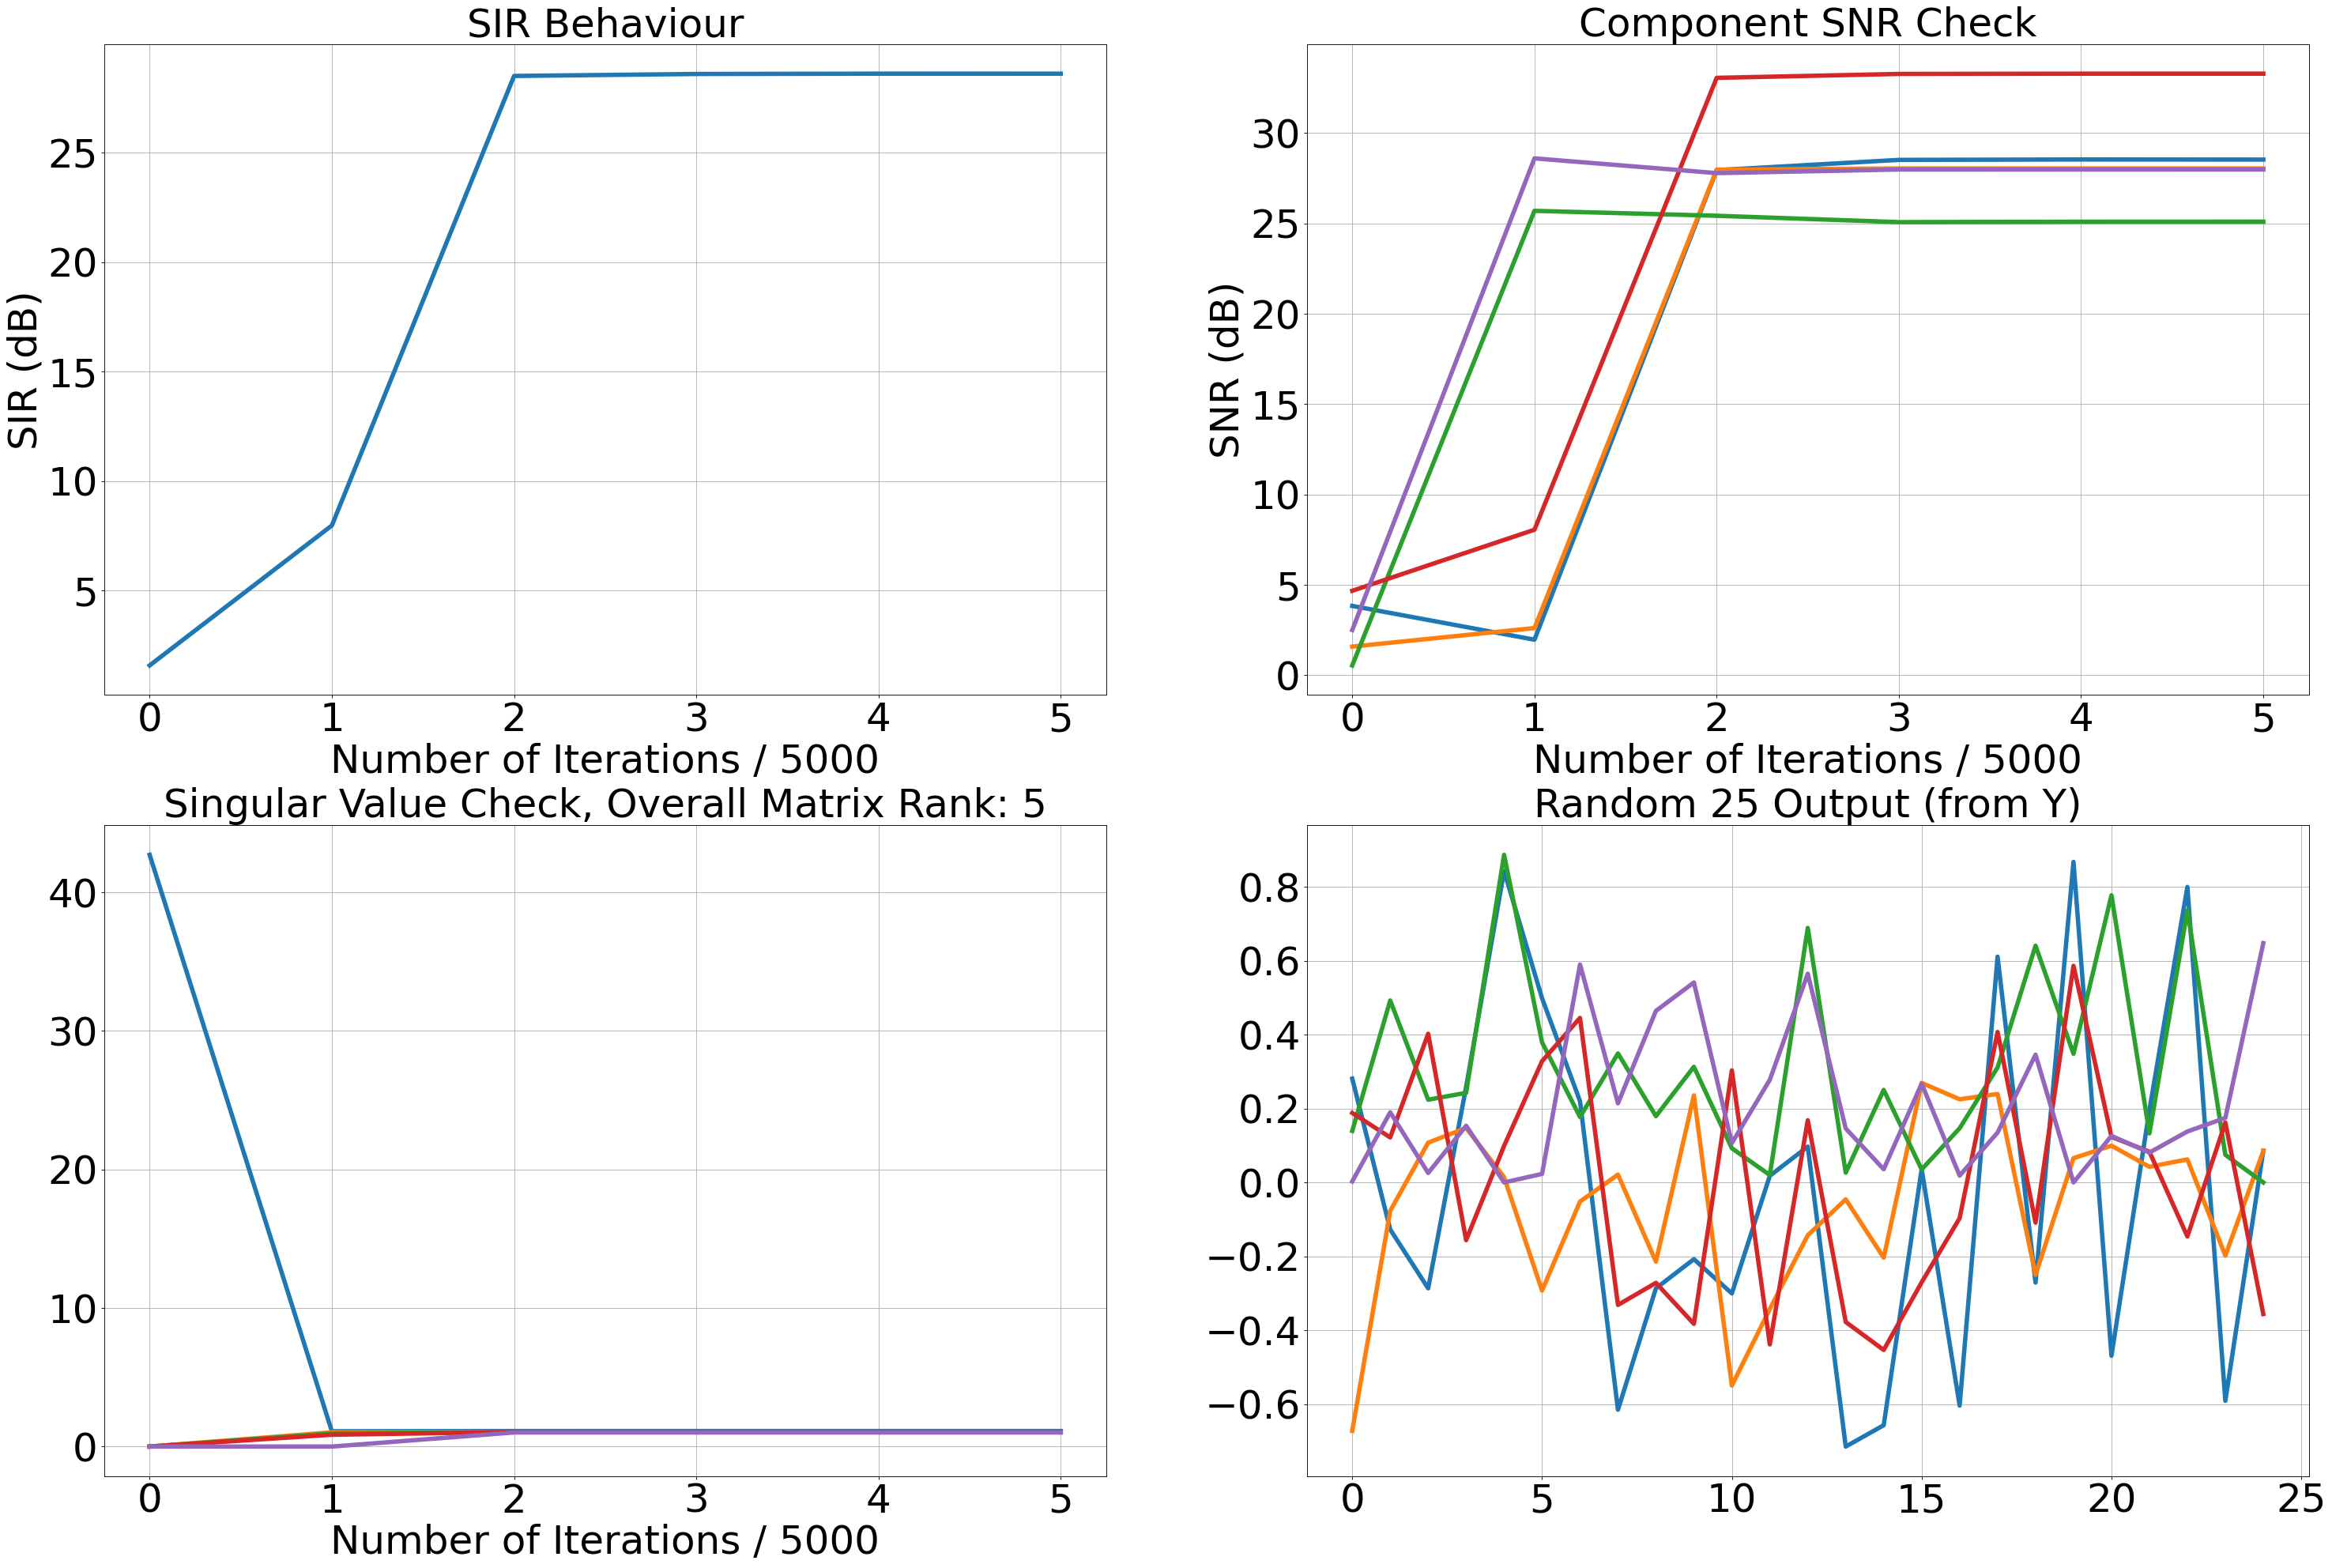

In [5]:
model.fit_batch_general_polytope(
    Y,
    n_iterations=25000,
    signed_dims=signed_dims,
    nn_dims=nn_dims,
    sparse_dims_list=sparse_dims_list,
    Lt=250,
    lambda_=28,
    tau=1,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Calculate Resulting Component SNRs and Overall SINR

In [6]:
Y = model.S
Y_ = signed_and_permutation_corrected_sources(Sgt, Y)
coef_ = ((Y_ * Sgt).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Sgt, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, Sgt)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [28.52785932 28.03684278 25.09047946 33.2822917  27.97988446]

Overall SINR : 28.612056823870855


# Vizualize Extracted Signals Compared to Original Sources

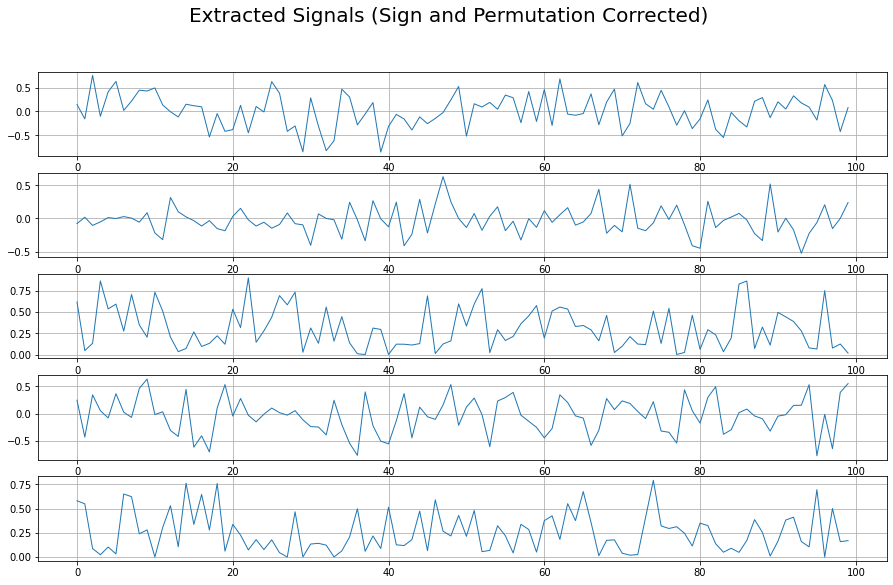

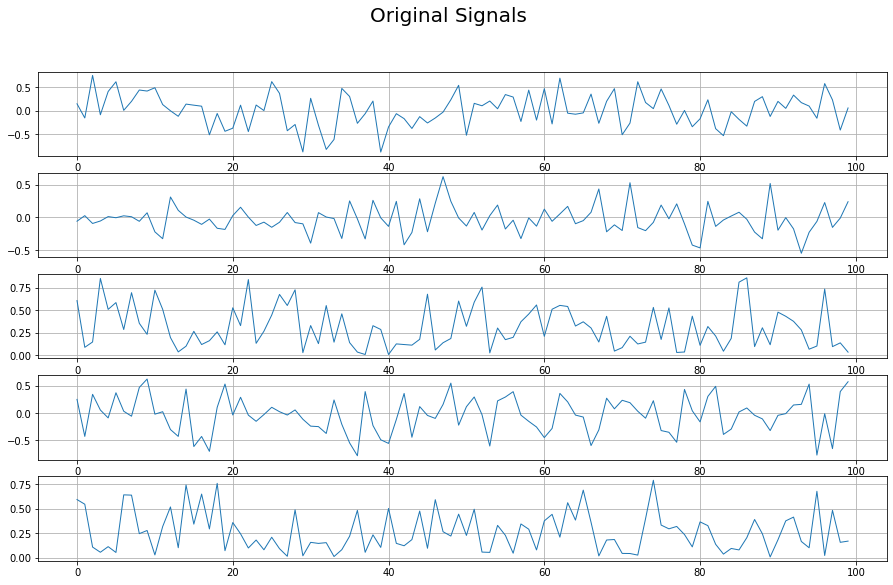

In [7]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    Sgt[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)